In [1]:
import os
import pandas as pd
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Directory setup
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
normal_images_dir = os.path.join(base_dir, "NORMAL")
pneumonia_images_dir = os.path.join(base_dir, "PNEUMONIA")

# Collecting images
normal_images = [os.path.join(normal_images_dir, x) for x in os.listdir(normal_images_dir) if x.endswith('.jpeg')][:500]
pneumonia_images = [os.path.join(pneumonia_images_dir, x) for x in os.listdir(pneumonia_images_dir) if x.endswith('.jpeg')][:500]

# Image transformations
transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])  # Normalize for grayscale images
])

# Custom Dataset Class for Generator (Pneumonia Images)
class PneumoniaDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Custom Dataset Class for Discriminator (Normal Images)
class NormalDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image

# DataLoaders
pneumonia_dataset = PneumoniaDataset(pneumonia_images, transform=transform)
normal_dataset = NormalDataset(normal_images, transform=transform)

pneumonia_loader = DataLoader(pneumonia_dataset, batch_size=32, shuffle=True)
normal_loader = DataLoader(normal_dataset, batch_size=32, shuffle=True)

# Length of DataLoader and example access
print("Pneumonia DataLoader batches:", len(pneumonia_loader))
print("Normal DataLoader batches:", len(normal_loader))

for images in pneumonia_loader:
    print(images.shape)  # Expecting [batch_size, 1, 256, 256]
    break

for images in normal_loader:
    print(images.shape)  # Expecting [batch_size, 1, 256, 256]
    break

Pneumonia DataLoader batches: 16
Normal DataLoader batches: 16
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])


In [2]:
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.downsample = nn.Sequential(
            # input: 1 x 256 x 256
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # output: 64 x 128 x 128
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # output: 128 x 64 x 64
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # output: 256 x 32 x 32
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # output: 512 x 16 x 16
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 512 x 32 x 32
            conv3x3(512, 256), 
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 256 x 64 x 64
            conv3x3(256, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 128 x 128 x 128
            conv3x3(128, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 64 x 256 x 256
            conv3x3(64, 1),
            nn.Tanh()  # Final output: 1 x 256 x 256
        )

    def forward(self, x):
        x = self.downsample(x)
        x = self.upsample(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 1 x 256 x 256
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # Output: 128 x 128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: 64 x 64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: 32 x 32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output: 16 x 16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # Output: 8 x 8
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1),  # Output: 4 x 4
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2048, 1, kernel_size=3, stride=1, padding=0),  # Output: 1 x 1
            nn.AdaptiveAvgPool2d(1),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)  # Flatten the output to ensure it is [batch_size]

In [4]:
def visualize_images(real_images, transformed_images, epoch, save_dir):
    real_images = real_images.detach().cpu()
    transformed_images = transformed_images.detach().cpu()
    
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(real_images[i].squeeze(0), cmap='gray')
        axes[1, i].imshow(transformed_images[i].squeeze(0), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')

    plt.savefig(os.path.join(save_dir, f'epoch_{epoch+1}.png'))
    plt.show()
    plt.close(fig)

Training with lambda1 = 0.0
Epoch 10/100: Loss_D: 0.0119, Loss_G: 4.5993, Perceptual Loss: 0.1984, Probability Loss: 3.6596, D(x): 0.9326, D(G(z)): 0.0644 / 0.0731


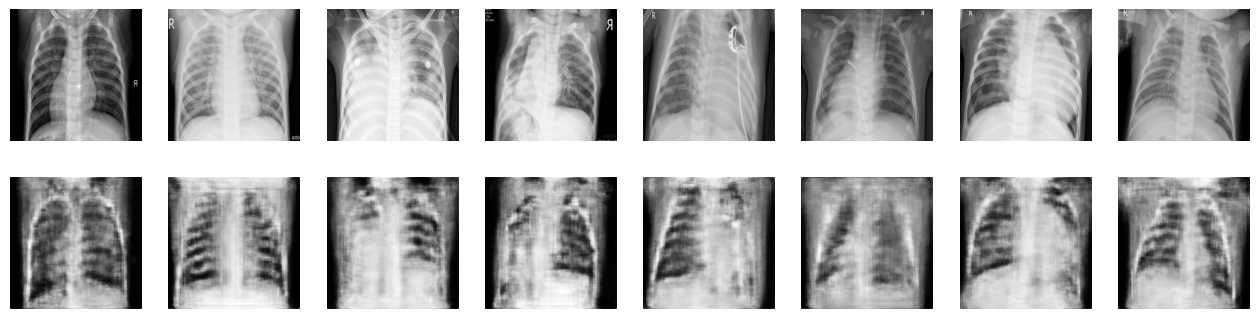

KeyboardInterrupt: 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torchvision import models

# Define the classifier model
classifier_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
classifier_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for 1-channel input
classifier_model_num_ftrs = classifier_model.fc.in_features
classifier_model.fc = nn.Linear(classifier_model_num_ftrs, 2)

# Define a function to load the pretrained classifier model
def load_model(path, model):
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode
    return model

# Load the classifier model
classifier_model = load_model("/kaggle/input/classifier/pytorch/default/1/best_resnet18_model.pth", classifier_model)
def train_gan_for_lambda(generator, discriminator, pneumonia_loader, normal_loader, classifier_model, lambda1_values, lambda2, num_epochs=100, save_dir='/kaggle/working'):
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()  # Adding L1 Loss for perceptual similarity
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    loss_dict = {f'lambda_{lambda1:.1f}': {'D': [], 'G': []} for lambda1 in lambda1_values}

    classifier_model.to(device)
    classifier_model.eval()  # Set classifier model to evaluation mode

    for lambda1 in lambda1_values:
        print(f"Training with lambda1 = {lambda1}")
        
        # Reinitialize the optimizers and schedulers for each lambda value
        optimizerD = optim.Adam(discriminator.parameters(), lr=0.00002, betas=(0.5, 0.999))
        optimizerG = optim.Adam(generator.parameters(), lr=0.00002, betas=(0.5, 0.999))
        schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=10, gamma=0.1)
        schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=10, gamma=0.1)

        generator.to(device)
        discriminator.to(device)

        real_label = 1.0
        fake_label = 0.0

        for epoch in range(num_epochs):
            running_lossD = 0.0
            running_lossG = 0.0
            
            for pneumonia_data, normal_data in zip(pneumonia_loader, normal_loader):
                normal_images = normal_data.to(device)
                pneumonia_images = pneumonia_data.to(device)
                batch_size = normal_images.size(0)

                # Train Discriminator on real images
                real_outputs = discriminator(normal_images)
                lossD_real = mse_loss(real_outputs, torch.full((batch_size,), real_label, dtype=torch.float, device=device))

                # Generate fake images from pneumonia data
                fake_images = generator(pneumonia_images)
                fake_outputs = discriminator(fake_images.detach())
                lossD_fake = mse_loss(fake_outputs, torch.full((batch_size,), fake_label, dtype=torch.float, device=device))

                # Update Discriminator
                discriminator.zero_grad()
                lossD = (lossD_real + lossD_fake) / 2
                lossD.backward()
                optimizerD.step()

                # Update Generator with perceptual loss and classifier-based probability loss
                generator.zero_grad()
                output_gen = discriminator(fake_images)
                lossG = mse_loss(output_gen, torch.full((batch_size,), real_label, dtype=torch.float, device=device))
                perceptual_loss = l1_loss(fake_images, pneumonia_images)  # Enforcing similarity

                # Classifier-based probability loss
                with torch.no_grad():
                    prob_normal = classifier_model(normal_images).mean(dim=0)[0]  # Average probability of normal class
                    prob_fake = classifier_model(fake_images).mean(dim=0)[0]  # Average probability of fake (generated) images being classified as normal

                prob_loss = lambda2 * torch.abs(prob_normal - prob_fake)

                total_gen_loss = lossG + lambda1 * perceptual_loss + prob_loss  # Combine losses with weighting factors
                total_gen_loss.backward()
                optimizerG.step()

                running_lossD += lossD.item()
                running_lossG += total_gen_loss.item()

            loss_dict[f'lambda_{lambda1:.1f}']['D'].append(running_lossD / len(pneumonia_loader))
            loss_dict[f'lambda_{lambda1:.1f}']['G'].append(running_lossG / len(pneumonia_loader))

            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}: '
                      f'Loss_D: {running_lossD / len(pneumonia_loader):.4f}, Loss_G: {running_lossG / len(pneumonia_loader):.4f}, '
                      f'Perceptual Loss: {perceptual_loss.item():.4f}, Probability Loss: {prob_loss.item():.4f}, '
                      f'D(x): {real_outputs.mean().item():.4f}, D(G(z)): {fake_outputs.mean().item():.4f} / {output_gen.mean().item():.4f}')
                
                # Visualize images
                with torch.no_grad():
                    visualize_images(pneumonia_images[:8], fake_images[:8], epoch, save_dir)

            schedulerD.step()
            schedulerG.step()

        # Save model weights after training with the current lambda1 value
        torch.save(generator.state_dict(), os.path.join(save_dir, f'generator_lambda_{lambda1:.1f}.pth'))
        torch.save(discriminator.state_dict(), os.path.join(save_dir, f'discriminator_lambda_{lambda1:.1f}.pth'))

    # Plotting the losses for all lambdas
    plt.figure(figsize=(10, 7))
    for lambda1 in lambda1_values:
        plt.plot(range(1, num_epochs + 1), loss_dict[f'lambda_{lambda1:.1f}']['D'], label=f'D_loss_lambda_{lambda1:.1f}')
        plt.plot(range(1, num_epochs + 1), loss_dict[f'lambda_{lambda1:.1f}']['G'], label=f'G_loss_lambda_{lambda1:.1f}')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs for different lambda values')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'loss_vs_epochs.png'))
    plt.show()

# Define the range of lambda1 values
lambda1_values = [i * 0.1 for i in range(11)]  # Generates [0.0, 0.1, 0.2, ..., 1.0]
lambda2 = 0.5  # Define lambda2 scaling factor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)
# Assume pneumonia_loader and normal_loader are already defined
train_gan_for_lambda(generator, discriminator, pneumonia_loader, normal_loader, classifier_model, lambda1_values, lambda2, 100, '/kaggle/working')